In [1]:
# Parameters
# Capacitté determiné par : qté totale d'energie dipso = un peu plus que la quantité totae d'energie pour satisfaire la demande fixée (D = 1000 kg/h par exemple)
# Problème d'optim pour determiner les capacité à installer ?
# Cout d'installation => meilleure résilience / constance de la rpoduction => obtenue avec les couts d'installation  de stockage
# capa * sum(profle) =  0.95 * Demand * Time (0.95 arbitraire, à ajuster)
wind_capa = None # Tbd as said above
solar_capa = None # Tbd as said above
wind_profile = None # Tbd from the database, depending on the year
solar_profile = None # Tbd from the database, depending on the year

# First steps, using a whole year of data (we have 3 such years)
# determination des capacités de stockage  => min de cappex + curtailment costs + imports
# Coût de l'import / curtaiilment => très hauts & constants, pour être utilisés en dernier recours 

In [2]:
from pulp import *
import matplotlib.pyplot as plt
from default_values import *
from load_profiles import *
from solver import *

In [3]:
solver_list = listSolvers(onlyAvailable=True)
print(solver_list)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-21
['GUROBI', 'GUROBI_CMD', 'PULP_CBC_CMD']


In [4]:
filename = "profiles.csv"
wind_column, solar_column = "DE_wind_profile", "DE_solar_profile"
df = load_profiles(filename, [wind_column, solar_column])

In [5]:
# We keep the year 2015, 2016 and 2017 for now
years = [2015, 2016, 2017]
wind_profiles = {}
solar_profiles = {}
for year in years:
    wind_profiles[year] = df[wind_column].filter(like = str(year), axis = 0)
    solar_profiles[year] = df[solar_column].filter(like = str(year), axis = 0)

In [11]:
# We use the default values for now
D = 1000
BAT_SIZE = 5000
TANK_SIZE = 5 * D
time_index = wind_profiles[2015].index
wind_profile = wind_profiles[2015].values
solar_profile = solar_profiles[2015].values
# We decide on a mix of wind and solar
# For example, 25% of the energy comes from solar and 75% from wind
wind_share = 0.75
Total_energy_needed = D * len(wind_profile) * EELEC * 1.05 # in MWh, with a 5% safety margin
wind_capa = Total_energy_needed * wind_share / sum(wind_profile)
solar_capa = Total_energy_needed * (1 - wind_share) / sum(solar_profile)


In [12]:
output = solve_fixed_prod_storage_capa(wind_capa, wind_profile, solar_capa, solar_profile, BAT_SIZE, TANK_SIZE, D)

Set parameter Username
Set parameter LogFile to value "gurobi.log"
Academic license - for non-commercial use only - expires 2024-11-21
Using license file /opt/gurobi1003/gurobi.lic

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)
Copyright (c) 2023, Gurobi Optimization, LLC

Read LP format model from file /tmp/83e41b87f75d439a96126bd62e5c680f-pulp.lp
Reading time = 0.17 seconds
OBJ: 87604 rows, 70082 columns, 166444 nonzeros

CPU model: Intel(R) Core(TM) i5-8350U CPU @ 1.70GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 87604 rows, 70082 columns and 166444 nonzeros
Model fingerprint: 0xc731e99e
Coefficient statistics:
  Matrix range     [5e-02, 1e+00]
  Objective range  [1e+03, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+03]
Presolve removed 74567 rows and 40030 columns
Presolve time: 0.19s
Presolved: 13037 rows, 30052 columns, 47103 nonzeros

Concurrent LP opti

In [13]:
prod_out = output["prod"]
charge_out = output["charge"]
stock_out = output["stock"]
elec_out = output["elecGrid"]
curtailment_out = output["curtail"]
consPPA_out = output["consPPA"]
print(output.keys())

dict_keys(['charge', 'prod', 'stock', 'elecGrid', 'curtail', 'consPPA', 'flowBat', 'flowH2'])


Text(0.5, 1.0, 'H2 production and stock, constant demand of 1000 Kg')

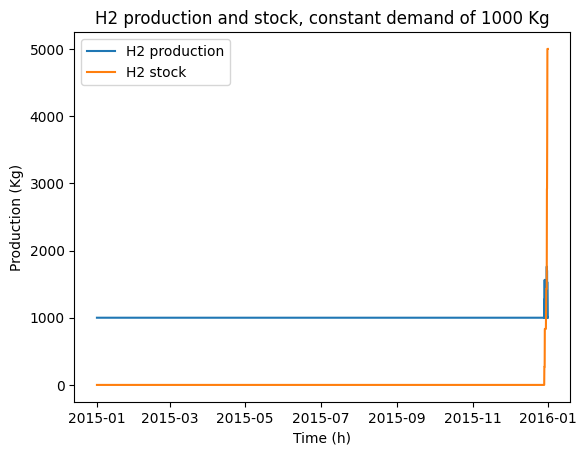

In [14]:
# Plot the production
fig, ax = plt.subplots()


ax.plot(time_index, prod_out, label = "H2 production")
ax.plot(time_index, stock_out[:-1], label = "H2 stock")
ax.legend()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Production (Kg)")
ax.set_title(f"H2 production and stock, constant demand of {D} Kg")

Text(0.5, 1.0, 'Consumptions')

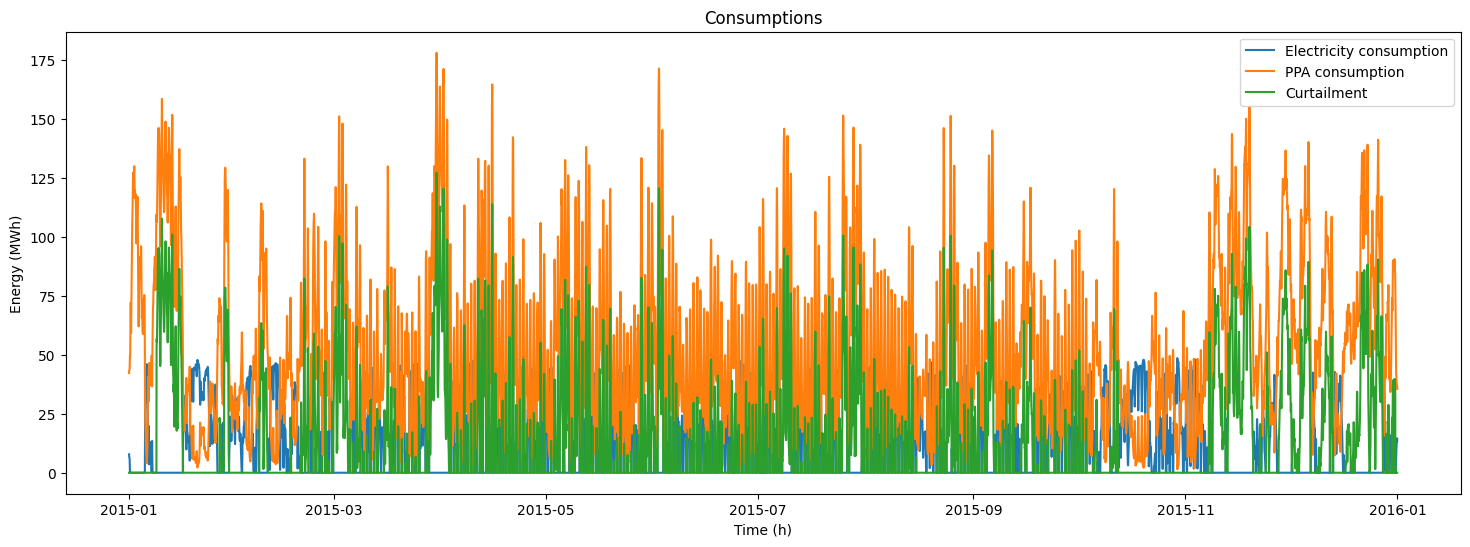

In [15]:
fig = plt.figure(figsize = (18, 6))
# Plot the consumptions
ax = fig.add_subplot(111)
ax.plot(time_index, elec_out, label="Electricity consumption")
ax.plot(time_index, consPPA_out, label="PPA consumption")
ax.plot(time_index, curtailment_out, label="Curtailment")
#ax.plot(time_index, charge_out[:-1], label="Battery charge")
ax.legend()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Energy (MWh)")
ax.set_title("Consumptions")